<a href="https://colab.research.google.com/github/mafie1/IA-pour-la-physique/blob/main/IA_pour_la_physique_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project - Intelligence artificielle pour la physique

#### General imports

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import pandas as pd
from tqdm import tqdm

from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint

#### Sklearn imports

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [5]:
#from google.colab import drive
#from google.colab import drive
#drive.mount('/content/drive')
#drive.mount('/content/gdrive')
#!ls '/content/gdrive/My Drive/IA pour la physique'

## Partie 1: Exploration des données

In [6]:
#@title Read in data
def read_t(t,root="./Ising/"):
    data = pickle.load(open(root+'Ising2DFM_reSample_L40_T=%.2f.pkl'%t,'rb'))
    return np.unpackbits(data).astype(int).reshape(-1, 1600)

In [7]:
!pwd

/export/compvis-nfs/user/lneubaue/IA-pour-la-physique


In [8]:
#%cd /content/gdrive/My Drive/IA pour la physique
!ls

CNN_accuracy_loss.png		best_model.h5
IA_pour_la_physique_main.ipynb	heatmap_confusion.png
Ising				pca_dim_one_temperature.png
PCA_variance_lin.png		scattering_pca.png
PCA_variance_log.png		temperature_grid_images.png
README.md


In [9]:
t_0 = 2.25
T_s = np.linspace(0.25, 4, 16)
print(*T_s)

data_0 = read_t(t_0, root="./Ising/")

0.25 0.5 0.75 1.0 1.25 1.5 1.75 2.0 2.25 2.5 2.75 3.0 3.25 3.5 3.75 4.0


**nombre et dimension**

In [10]:
data_0.shape

(10000, 1600)

In [11]:
sample_image_0_25 = read_t(0.25, root="./Ising/")[0, :].reshape(40, 40)
sample_image_0_50 = read_t(0.50, root="./Ising/")[0, :].reshape(40, 40)
sample_image_0_75 = read_t(0.75, root="./Ising/")[0, :].reshape(40, 40)
sample_image_2_25 = data_0[0, :].reshape(40, 40)
sample_image_4_00 = read_t(4.0, root="./Ising/")[0, :].reshape(40, 40)

 For each temperature, we have $10^4$ states on a grid with 40x40 = 1600 positions.


**nom, signification et type (numérique/catégoriel) des variables**

In [12]:
"""min_val, max_val = 0, 1

cm = sns.light_palette("blue", as_cmap=True)
x = pd.DataFrame(sample_image)
x = x.style.background_gradient(cmap=cm)
display(x)"""

'min_val, max_val = 0, 1\n\ncm = sns.light_palette("blue", as_cmap=True)\nx = pd.DataFrame(sample_image)\nx = x.style.background_gradient(cmap=cm)\ndisplay(x)'

In [13]:
X_input = np.empty((16, 10000, 1600))
y_input = np.empty((16, 10000))

for i, t in enumerate(tqdm(T_s)):
  X_input[i] = read_t(t, root="./Ising/")
  y_input[i] = t

100%|██████████| 16/16 [00:00<00:00, 25.85it/s]


In [14]:
inv_temp = [1/t for t in T_s] # define the inverse temperature
print(*inv_temp)

4.0 2.0 1.3333333333333333 1.0 0.8 0.6666666666666666 0.5714285714285714 0.5 0.4444444444444444 0.4 0.36363636363636365 0.3333333333333333 0.3076923076923077 0.2857142857142857 0.26666666666666666 0.25


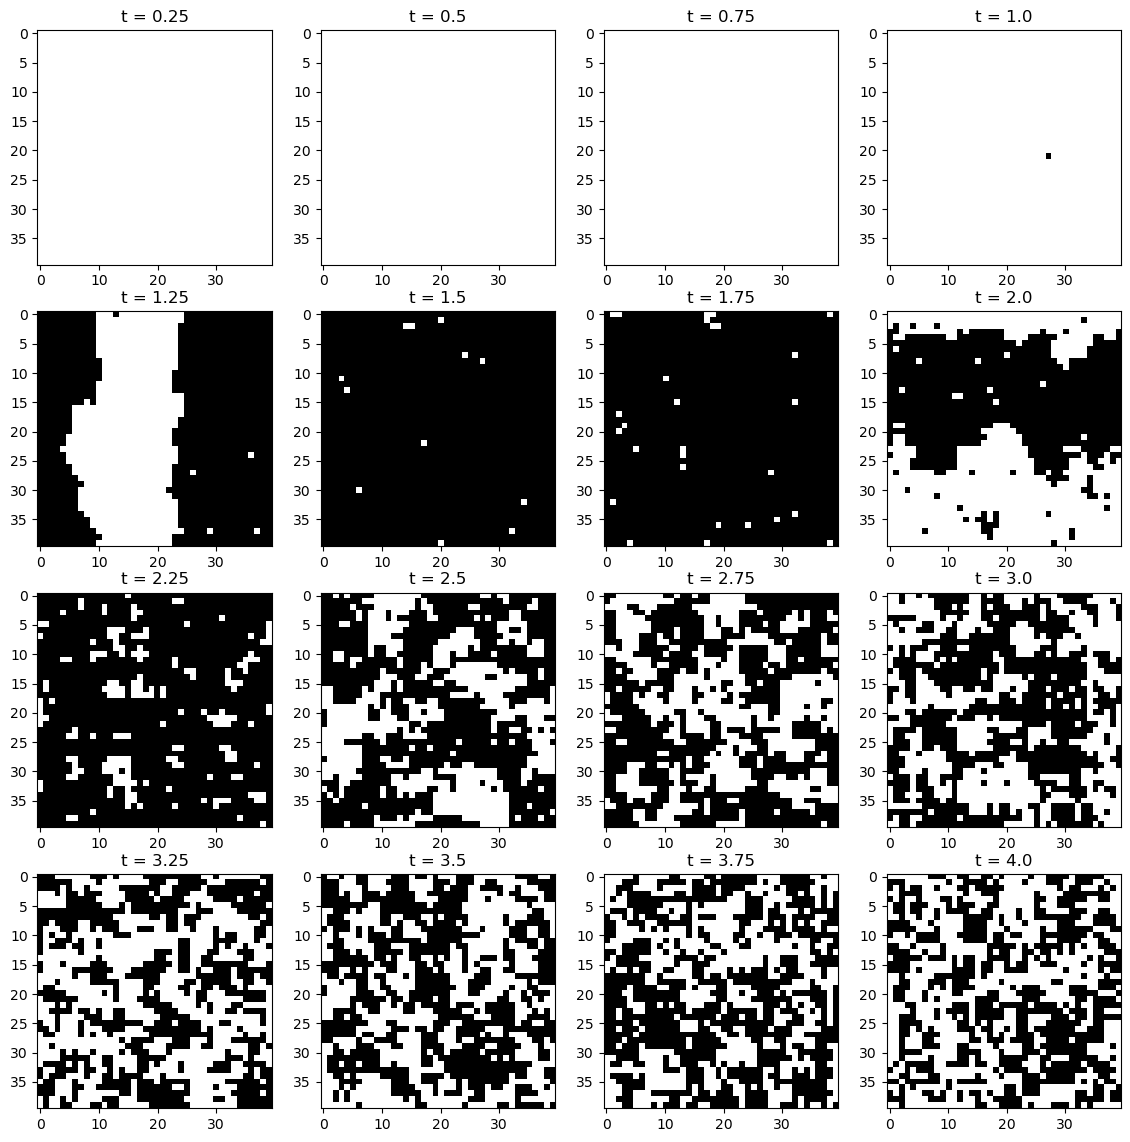

In [15]:
#f, axarr = plt.subplots(4,4)
plt.figure(figsize=(14,14))

for i, t in enumerate(T_s):
  plt.subplot(4,4,i+1)

  plt.imshow(X_input[i][0].reshape(40, 40), cmap = 'Greys')
  plt.title('t = %s' %((i+1)*0.25))

plt.savefig('temperature_grid_images')

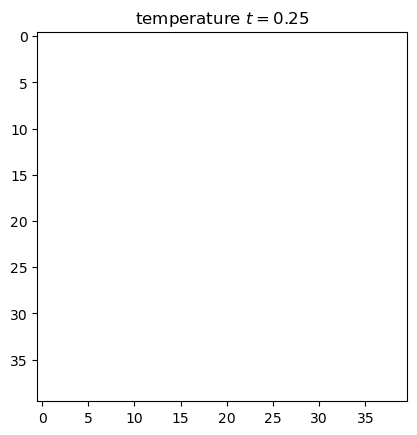

In [16]:
plt.title(r'temperature $t = 0.25$')
plt.imshow(sample_image_0_25, cmap = 'Greys')

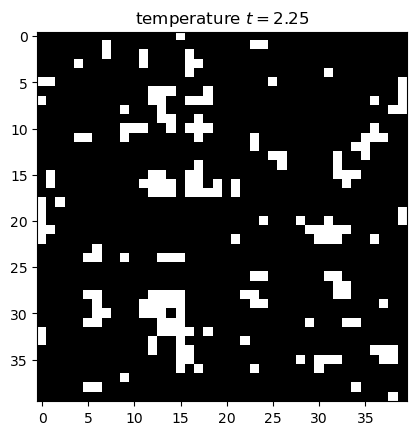

In [17]:
plt.title(r'temperature $t = 2.25$')
plt.imshow(sample_image_2_25, cmap = 'Greys')

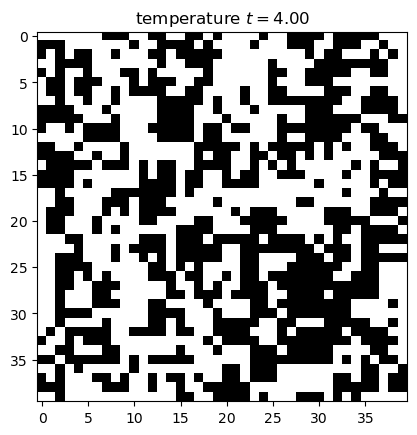

In [18]:
plt.title(r'temperature $t = 4.00$')
plt.imshow(sample_image_4_00, cmap = 'Greys')

**y a-t-il des données manquantes ?**

In [19]:
# no

**préciser la nature du problème (classification/régression)** <br>
Les autheurs du papier '...' traitent ce problème comme un problème de classification sur les 16 categories = les temperatures.

**définir les objectifs et la métrique d’évaluation**

## Partie 2: Préparation des données




**séparation entraînement/test et mettre les données de test de côté**
We will make an 80-10-10 split

In [20]:
#reshape to get 16*10^4 training samples each with 1600 features
X_input = X_input.reshape(-1, 1600)
y_input = y_input.reshape(-1)

In [21]:
#get initial split between data used for verification (test + val) & training
X_train, X_ver, y_train, y_ver  = train_test_split(X_input, y_input, train_size = 0.8, random_state = 0)

print(X_train.shape, X_ver.shape)
print(y_train.shape, y_ver.shape)

(128000, 1600) (32000, 1600)
(128000,) (32000,)


In [22]:
# get validation data to do intermediary performance evaluation + hyperparameter optimization
X_test, X_val, y_test, y_val = train_test_split(X_ver, y_ver, train_size = 0.5, random_state = 0)

print(y_train.shape, y_val.shape)

(128000,) (16000,)


**examiner les statistiques des différents descripteurs (min, max,
moyenne, écart-type, distribution, corrélations)**

In [23]:
"""# Example DataFrame creation (replace this with your actual dataset)
np.random.seed(42)
num_samples = 160000
num_features = 1600
temperatures = np.linspace(0.25, 4.0, num_samples // 1600)
spin_configurations = np.random.choice([-1, 1], size=(num_samples, num_features))

ising_data = pd.DataFrame({
    'Temperature': temperatures,
    'SpinConfig': list(spin_configurations)
})

# Calculate correlation matrix
correlation_matrix = ising_data['SpinConfig'].apply(lambda x: pd.Series(x)).corr()"""

"# Example DataFrame creation (replace this with your actual dataset)\nnp.random.seed(42)\nnum_samples = 160000\nnum_features = 1600\ntemperatures = np.linspace(0.25, 4.0, num_samples // 1600)\nspin_configurations = np.random.choice([-1, 1], size=(num_samples, num_features))\n\nising_data = pd.DataFrame({\n    'Temperature': temperatures,\n    'SpinConfig': list(spin_configurations)\n})\n\n# Calculate correlation matrix\ncorrelation_matrix = ising_data['SpinConfig'].apply(lambda x: pd.Series(x)).corr()"

In [24]:
"""# Calculate min-max values per temperature
min_max_per_temp = ising_data.groupby('Temperature')['SpinConfig'].agg([np.min, np.max])

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, annot=True)
plt.title('Correlation Matrix')
plt.show()"""

"# Calculate min-max values per temperature\nmin_max_per_temp = ising_data.groupby('Temperature')['SpinConfig'].agg([np.min, np.max])\n\n# Plot correlation matrix\nplt.figure(figsize=(10, 8))\nsns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, annot=True)\nplt.title('Correlation Matrix')\nplt.show()"

**encoder initialement les descripteurs catégoriels sous forme ordinale**

In [25]:
# one hot encoding of temperatures y_train, y_test
my_encoding = OneHotEncoder()
my_encoding.fit(y_train.reshape(-1, 1))

OneHotEncoder()

In [26]:
y_train_enc = my_encoding.transform(y_train.reshape(-1, 1))
y_test_enc  = my_encoding.transform(y_test.reshape(-1, 1))

In [27]:
# Label encoding as alternative encoding
label_encoder = LabelEncoder()
label_encoder.fit(y_train.reshape(-1, 1))

/export/home/lneubaue/miniconda3/envs/IA_physique/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LabelEncoder()

In [28]:
y_train_label = label_encoder.transform(y_train)
y_test_label = label_encoder.transform(y_test)
y_val_label = label_encoder.transform(y_val)

In [29]:
print(np.shape(y_train_label))
print(np.shape(X_train))

(128000,)
(128000, 1600)


**examiner les statistiques des différents descripteurs (min, max,
moyenne, écart-type, distribution, corrélations)**

In [30]:
# get min, max number of up/down spins per temperature



**TO DO**: Check if dimensions inputted into Standard Scaler, PCA are correct

Scaling data for PCA:

In [31]:
my_scaler = StandardScaler()
X_train_scaled = my_scaler.fit_transform(X_train)

In [32]:
X_test_scaled = my_scaler.transform(X_test)
X_val_scaled = my_scaler.transform(X_val)

PCA of image data:

In [33]:
my_pca = PCA(n_components = 100)
X_train_pca = my_pca.fit_transform(X_train_scaled)

In [34]:
X_test_pca = my_pca.transform(X_test_scaled)
X_val_pca = my_pca.transform(X_val_scaled)

(128000, 100)


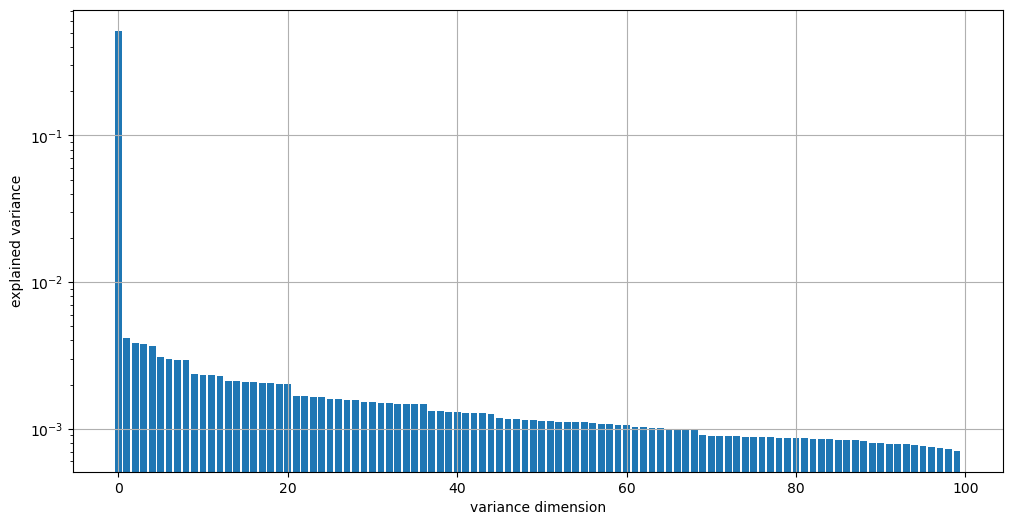

In [35]:
print(X_train_pca.shape)

plt.figure(figsize = (12, 6))
x_range = np.linspace(0, 1599, 1600)[:100]

plt.grid('on')
plt.bar(x_range, my_pca.explained_variance_ratio_[:100])

#plt.title('explained variance per PCA dimension (log scale)')
plt.yscale('log')
plt.ylabel('explained variance')
plt.xlabel('variance dimension')

plt.savefig('PCA_variance_log')

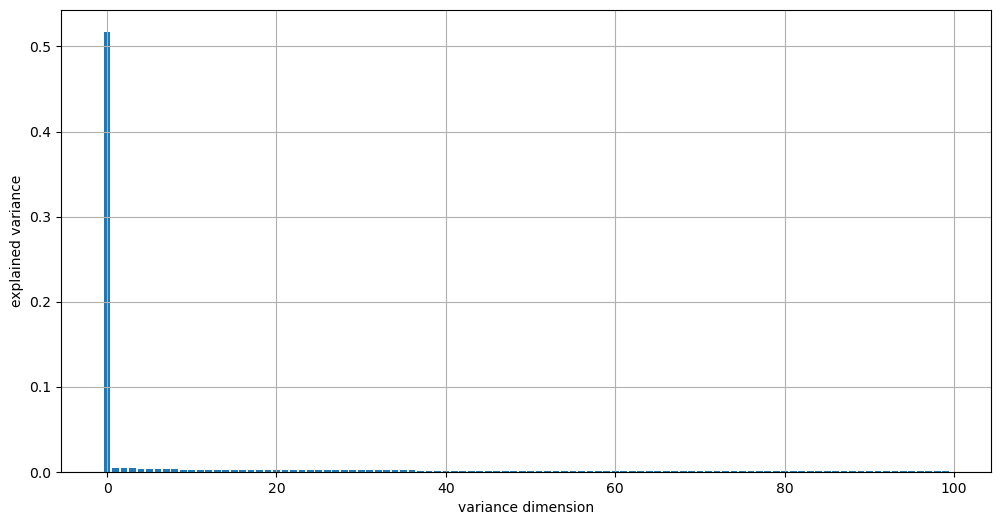

In [36]:
plt.figure(figsize = (12, 6))
plt.grid('on')
plt.bar(x_range, my_pca.explained_variance_ratio_[:100])
#plt.title('explained variance per PCA dimension (linear scale)')
plt.ylabel('explained variance')
plt.xlabel('variance dimension')
plt.savefig('PCA_variance_lin')

$\Rightarrow$ Most variance is contained in the first dimension and decreases afterwards

In [37]:
print(X_train_pca.shape)

(128000, 100)


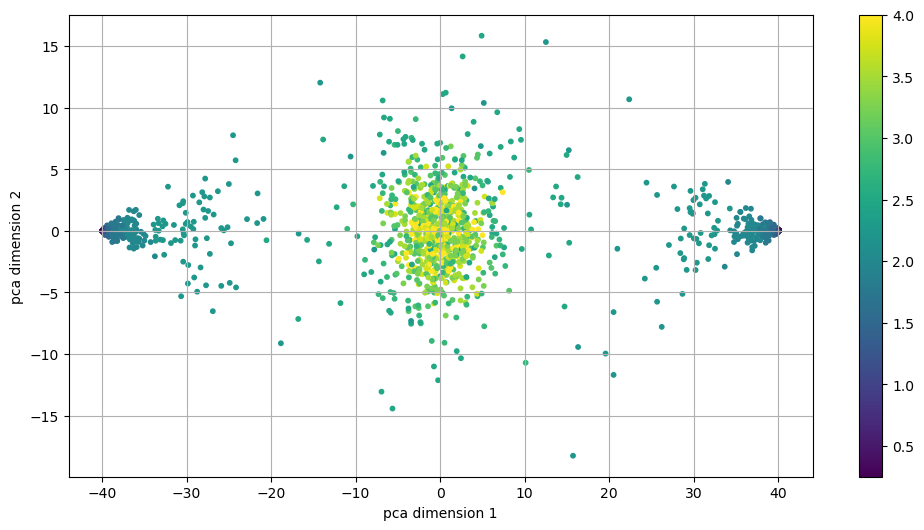

In [38]:
plt.figure(figsize = (12, 6))
plt.scatter(X_train_pca[:2000, 0], X_train_pca[:2000, 1], c = y_train[:2000], s = 10)
plt.colorbar()
plt.grid('on')
#plt.title(r'Representation pca dim. 1 & 2 with respective temperature $t$')
plt.ylabel('pca dimension 2')
plt.xlabel('pca dimension 1')

plt.savefig('scattering_pca')

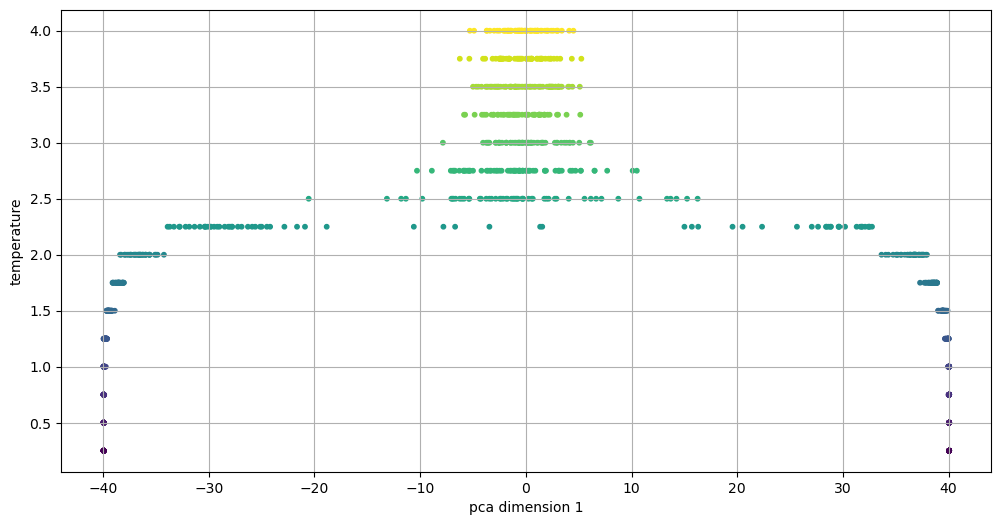

In [39]:
plt.figure(figsize = (12, 6))
plt.scatter(X_train_pca[:1000, 0], y = y_train[:1000], c = y_train[:1000], s = 10)
plt.grid('on')
#plt.title('most important PCA dimension & temperature (on train set)')
plt.xlabel('pca dimension 1')
plt.ylabel('temperature')
plt.savefig('pca_dim_one_temperature')


### Test several baseline models - logistic regression and SVM  *on PCA dims*

**Logistic Regression**

In [40]:
# logistic regression on the first 10 pca dimensions as a baseline model
%time
my_log_reg = LogisticRegression(random_state=0).fit(X_train_pca[:, :10], y_train_label)

CPU times: user 12 µs, sys: 6 µs, total: 18 µs
Wall time: 35 µs


In [41]:
my_log_reg.score(X_train_pca[:, :10], y_train_label)

0.12278125

In [42]:
val_score_log_reg = my_log_reg.score(X_val_pca[:, :10], y_val_label)

print('validation score logistic regression on PCA dims:', val_score_log_reg)

validation score logistic regression on PCA dims: 0.1228125


In [43]:
# logistic regression on all dimensions
%time
my_log_reg = LogisticRegression(random_state=0).fit(X_train, y_train_label)

CPU times: user 1.03 ms, sys: 704 µs, total: 1.73 ms
Wall time: 57.5 µs


/export/home/lneubaue/miniconda3/envs/IA_physique/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [44]:
my_log_reg.score(X_train, y_train_label)

0.165234375

In [45]:
val_score_log_reg = my_log_reg.score(X_val, y_val_label)

print('validation score logistic regression:', val_score_log_reg)

validation score logistic regression: 0.1100625


**Support Vector Machine**

In [46]:
# SVM on first 10 pca dimensions
%time
my_svm = LinearSVC(multi_class = 'ovr', max_iter = 200).fit(X_train_pca[:, :10], y_train_label)

CPU times: user 1.11 ms, sys: 584 µs, total: 1.69 ms
Wall time: 57.7 µs


/export/home/lneubaue/miniconda3/envs/IA_physique/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [47]:
my_svm.score(X_train_pca[:, :10], y_train_label)

0.0996640625

In [48]:
my_svm.score(X_val_pca[:, :10], y_val_label)

0.1049375

**création d’un processus de pré-traitement des données** (→ utiliser
l’outil pipeline de scikit-learn)
⋄ encodage des variables catégorielles
⋄ standardisation des variables numériques
⋄ traitement d’éventuelles données manquantes

In [49]:
# mean and std of images

#pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])


In [50]:
# Create new dataset for phase transition

## Partie 3: Détermination de scores de référence (sur les données de test)



**Regularized logistic regression**



In [51]:
# logistic regression model with regularization parameter from 1e-5 to 1e5

In [52]:
lmbdas = np.logspace(-1, 3, 9) #must be positive float! 
print(lmbdas)

train_accuracy = np.zeros(lmbdas.shape,np.float64)
validation_accuracy = np.zeros(lmbdas.shape,np.float64)
train_accuracy_SGD = np.zeros(lmbdas.shape,np.float64)
validation_accuracy_SGD =np.zeros(lmbdas.shape,np.float64)

[1.00000000e-01 3.16227766e-01 1.00000000e+00 3.16227766e+00
 1.00000000e+01 3.16227766e+01 1.00000000e+02 3.16227766e+02
 1.00000000e+03]


In [53]:
"""for i, lmbda in enumerate(tqdm(lmbdas)):
    # define logistic regressor
    logreg = LogisticRegression(C = lmbda, random_state=1, verbose=1, max_iter=500, tol=1E-5,
                                           solver='liblinear')

    # fit training data
    logreg.fit(X_train, y_train_label)

    # check accuracy
    train_accuracy[i]=logreg.score(X_train,y_train_label)
    validation_accuracy[i]=logreg.score(X_val, y_val_label)"""

"for i, lmbda in enumerate(tqdm(lmbdas)):\n    # define logistic regressor\n    logreg = LogisticRegression(C = lmbda, random_state=1, verbose=1, max_iter=500, tol=1E-5,\n                                           solver='liblinear')\n\n    # fit training data\n    logreg.fit(X_train, y_train_label)\n\n    # check accuracy\n    train_accuracy[i]=logreg.score(X_train,y_train_label)\n    validation_accuracy[i]=logreg.score(X_val, y_val_label)"

In [54]:
"""for i in range(len(lmbdas)):
  print('accuracy: train, validation')
  print('liblin: %0.4f, %0.4f' %(train_accuracy[i],validation_accuracy[i]) )"""

"for i in range(len(lmbdas)):\n  print('accuracy: train, validation')\n  print('liblin: %0.4f, %0.4f' %(train_accuracy[i],validation_accuracy[i]) )"

In [55]:
"""val_C = np.logspace(-5,5,11)
plt.figure(figsize=(6,6))
plt.grid('on')
plt.plot(val_C, train_accuracy,label = 'train accuracy')
plt.plot(val_C, validation_accuracy,label = 'validation accuracy')
plt.legend()
plt.xscale('log')
plt.xlabel('inverse of regularization parameter')
plt.ylabel('classification accuracy')"""

"val_C = np.logspace(-5,5,11)\nplt.figure(figsize=(6,6))\nplt.grid('on')\nplt.plot(val_C, train_accuracy,label = 'train accuracy')\nplt.plot(val_C, validation_accuracy,label = 'validation accuracy')\nplt.legend()\nplt.xscale('log')\nplt.xlabel('inverse of regularization parameter')\nplt.ylabel('classification accuracy')"

 **The logistic regression model with stronger regularization has better performance, so this means that there is noise in the original dataset. By selecting the most relevant feautures and train different models with these features may lead to better performance**

## Partie 4: Conception d’un modèle plus performant

In [56]:
# CNN
# preprocessing of images --> normalization (mean, std)?

# --> can we do data aufmentations, such as rotations and flips? They should be equivalent, valid states

**Multi-layer perceptron**

In [62]:
# firstly, we test the ordinary neuron network(multi-layer perceptron), without convolutional structure
from tensorflow import keras
from sklearn.metrics import confusion_matrix

nb_rows, nb_cols  = 40, 40 # the image is of 40*40 pixels

print('X_train shape:', X_train.shape, X_train.dtype)

X_train shape: (128000, 1600) float64


In [63]:
im_size = nb_rows*nb_cols
model = keras.models.Sequential()

nb_classes = 16 ## the samples to be classified are obtainned at 16 temperatures

model.add(keras.layers.Dense(100, input_shape=(im_size,), activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(nb_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               160100    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 16)                1616      
Total params: 171,816
Trainable params: 171,816
Non-trainable params: 0
_________________________________________________________________


In [73]:
model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=keras.optimizers.SGD(learning_rate=0.01),
                  metrics=['accuracy'])



# Define the filepath to save the best model
model_filepath = 'best_NN.h5'

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(model_filepath, monitor='val_acc', save_best_only=True, mode='max', verbose=1)

In [76]:
print(X_train.shape, y_train_label.shape)

batch_size = 64
epochs = 30

history = model.fit(X_train, y_train_label, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[checkpoint])

Train on 102400 samples, validate on 25600 samples
Epoch 1/30
100992/102400 [============================>.] - ETA: 0s - loss: 2.4433 - acc: 0.1360
Epoch 00001: val_acc improved from -inf to 0.17172, saving model to best_NN.h5
102400/102400 [==============================] - 4s 36us/sample - loss: 2.4409 - acc: 0.1362 - val_loss: 2.2557 - val_acc: 0.1717
Epoch 2/30
100992/102400 [============================>.] - ETA: 0s - loss: 2.1562 - acc: 0.1972
Epoch 00002: val_acc improved from 0.17172 to 0.21289, saving model to best_NN.h5
102400/102400 [==============================] - 4s 36us/sample - loss: 2.1556 - acc: 0.1975 - val_loss: 2.0910 - val_acc: 0.2129
Epoch 3/30
102016/102400 [============================>.] - ETA: 0s - loss: 1.9847 - acc: 0.2530
Epoch 00003: val_acc improved from 0.21289 to 0.25168, saving model to best_NN.h5
102400/102400 [==============================] - 3s 34us/sample - loss: 1.9842 - acc: 0.2533 - val_loss: 1.9578 - val_acc: 0.2517
Epoch 4/30
101312/102400 

In [77]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [78]:
epoch = np.arange(1, epochs+1)
train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0, 0.5, 'loss ')

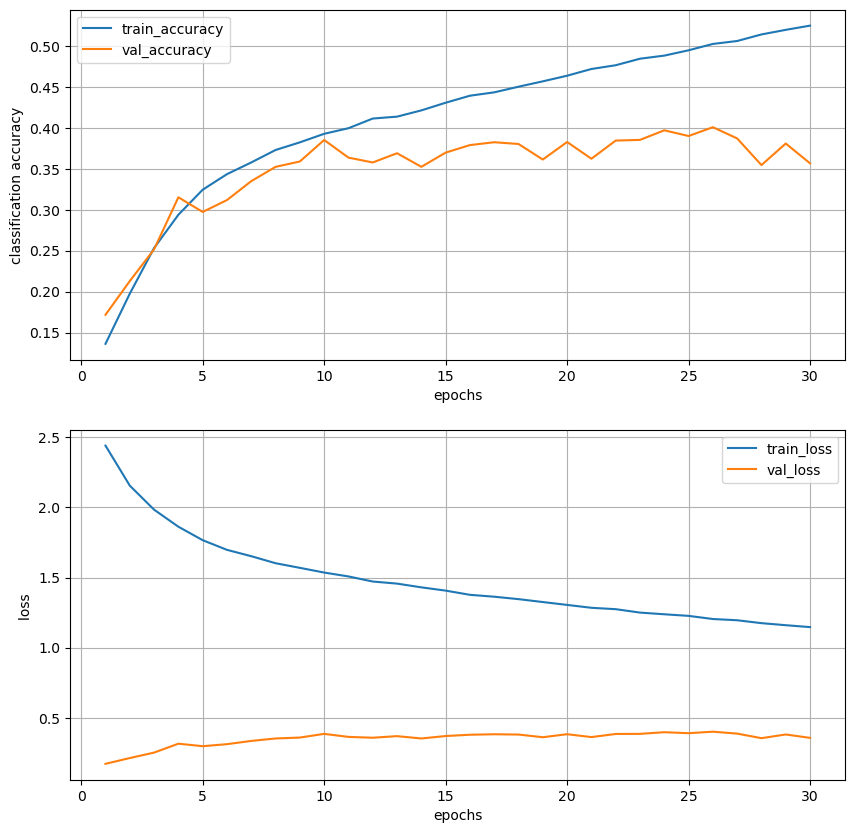

In [81]:
plt.figure(figsize=(10, 10))

plt.subplot(2,1,1)
plt.plot(epoch, train_accuracy, label = 'train_accuracy')
plt.plot(epoch, val_accuracy, label= 'val_accuracy')
plt.xlabel('epochs')
plt.ylabel('classification accuracy')
plt.grid('on')
plt.legend()

plt.subplot(2,1,2)
plt.plot(epoch,train_loss, label = 'train_loss')
plt.plot(epoch,val_accuracy, label= 'val_loss')
plt.legend()
plt.grid('on')
plt.xlabel('epochs')
plt.ylabel('loss ')

In [96]:
y_pred_label = model.predict(X_test)

best_model_NN = keras.models.load_model('best_NN.h5')

test_loss, test_accuracy = best_model_NN.evaluate(X_test, y_test_label)
print("Test Accuracy NN:", test_accuracy)

train_loss, train_accuracy = best_model_NN.evaluate(X_train, y_train_label)
print("Train Accuracy NN:", train_accuracy)

16000/16000 [==============================] - 0s 29us/sample - loss: 1.4681 - acc: 0.3984
Test Accuracy NN: 0.3984375
128000/128000 [==============================] - 3s 24us/sample - loss: 1.2032 - acc: 0.5067
Train Accuracy NN: 0.50666404


In [83]:
new_y_pred = np.zeros(np.shape(y_pred_label)[0])
for i in range(np.shape(y_pred_label)[0]):
  a = y_pred_label[i]
  new_y_pred[i] = np.argmax(a)

In [84]:
conf_16_16_matrix=confusion_matrix(y_test_label,new_y_pred)
conf_16_16_matrix

array([[  0, 487,   0,   0,   0,   0,   0, 519,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0, 488,   0,   0,   0,   0,   0, 490,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0, 470,   0,  11,   7,   0,   0, 478,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0, 325,   0,  77, 141,  13,   0, 481,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0, 103,   0,  45, 402,  75,   1, 362,   1,   0,   0,   0,   0,
          0,   0,   0],
       [  0,  90,   0,   0,  72, 431,  33, 360,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,  59,   0,   0,   0,  67, 426, 438,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   6,   0,   0,   0,   3,  28, 930,  30,   1,   0,   0,   0,
          0,   0,   1],
       [  0,   0,   0,   0,   0,   0,   0, 201, 696,  51,  10,   1,   1,
          1,   0,  35],
       [  0,   0,   0,   0,   0,   0,   0,   1,  34, 350, 503,  35,  77,
          9,   1,   5],
       [  0,   0,   0,   0,   

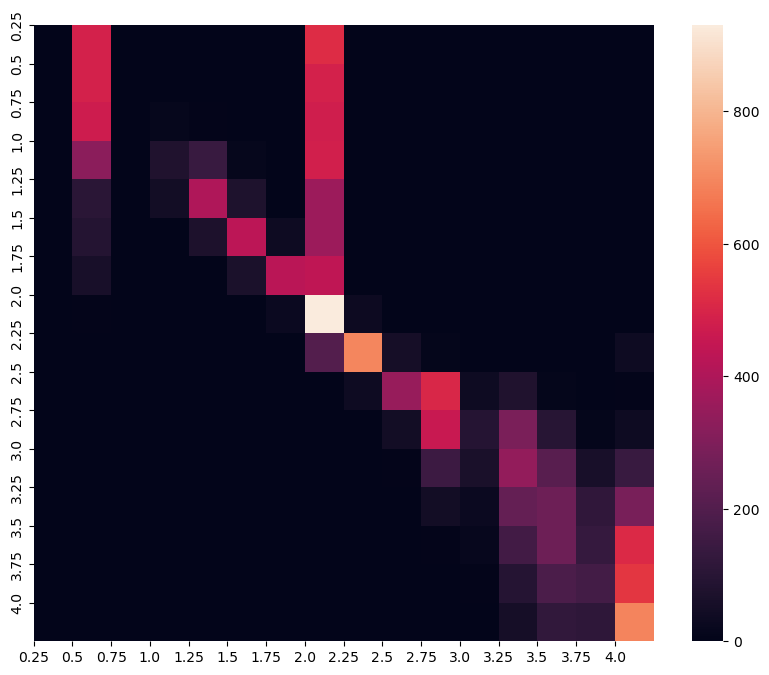

In [97]:
plt.figure(figsize=(10,8))

sns.heatmap(conf_16_16_matrix) # confusion matrix for 16 classification categories, is it resonable to consider less classes?

plt.xticks(np.arange(16), np.linspace(0.25, 4, 16))
plt.yticks(np.arange(16), np.linspace(0.25, 4, 16))

plt.savefig('heatmap_confusion.png')

**Generally, the multi-layer perceptron model can classify the samples at 16 different temperatures with an accuracy around 40%**

**Covolutional neronal network**

**Now, we will add the convolutionary structure to the neuroal network to see if this will improve the model performance**

In [86]:
nb_rows = 40
nb_cols = 40
nb_classes = 16
X_train_2D = X_train.reshape(X_train.shape[0], nb_rows, nb_cols, 1)
X_test_2D = X_test.reshape(X_test.shape[0], nb_rows, nb_cols, 1)

print('X_train shape:', X_train_2D.shape, X_train.dtype)
print('y_train shape (one-hot encoding):', y_train_label.shape, y_train_label.dtype)

print('X test shape:', X_test_2D.shape, X_test.dtype)

X_train shape: (128000, 40, 40, 1) float64
y_train shape (one-hot encoding): (128000,) int64
X test shape: (16000, 40, 40, 1) float64


In [87]:
model_CNN = keras.models.Sequential()

model_CNN.add(keras.layers.Conv2D(20, kernel_size=(5, 5),
                                  activation='relu',
                                  input_shape=(nb_rows,nb_cols,1)))
model_CNN.add(keras.layers.Flatten())

model_CNN.add(keras.layers.Dense(nb_classes, activation='softmax'))

In [88]:
batch_size = 128
epochs = 30

model_CNN.compile(loss='sparse_categorical_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])

# Define the filepath to save the best model
model_filepath = 'best_CNN.h5'

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint(model_filepath, monitor='val_acc', save_best_only=True, mode='max', verbose=1)

# Fit the model with the callback
history = model_CNN.fit(X_train_2D, y_train_label, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[checkpoint])

Train on 102400 samples, validate on 25600 samples
Epoch 1/30
101888/102400 [============================>.] - ETA: 0s - loss: 1.6703 - acc: 0.3412
Epoch 00001: val_acc improved from -inf to 0.40820, saving model to best_CNN.h5
102400/102400 [==============================] - 8s 81us/sample - loss: 1.6686 - acc: 0.3416 - val_loss: 1.3787 - val_acc: 0.4082
Epoch 2/30
101632/102400 [============================>.] - ETA: 0s - loss: 1.1947 - acc: 0.5089
Epoch 00002: val_acc improved from 0.40820 to 0.48691, saving model to best_CNN.h5
102400/102400 [==============================] - 8s 82us/sample - loss: 1.1947 - acc: 0.5087 - val_loss: 1.2272 - val_acc: 0.4869
Epoch 3/30
101760/102400 [============================>.] - ETA: 0s - loss: 1.0650 - acc: 0.5598
Epoch 00003: val_acc improved from 0.48691 to 0.49898, saving model to best_CNN.h5
102400/102400 [==============================] - 8s 82us/sample - loss: 1.0652 - acc: 0.5595 - val_loss: 1.1634 - val_acc: 0.4990
Epoch 4/30
101632/1024

In [89]:
epoch = np.arange(1, epochs+1)
CNN_train_accuracy = history.history['acc']
CNN_val_accuracy = history.history['val_acc']
CNN_train_loss = history.history['loss']
CNN_val_loss = history.history['val_loss']

In [90]:
from tensorflow.keras.models import load_model
best_model = load_model('best_CNN.h5')

In [91]:
test_loss, test_accuracy = best_model.evaluate(X_test_2D, y_test_label)
print("Test Accuracy:", test_accuracy)

   32/16000 [..............................] - ETA: 12s - loss: 1.3782 - acc: 0.3438

16000/16000 [==============================] - 1s 43us/sample - loss: 1.1675 - acc: 0.5180
Test Accuracy: 0.518


In [92]:
train_loss, train_accuracy = best_model.evaluate(X_train_2D, y_train_label)

128000/128000 [==============================] - 5s 40us/sample - loss: 0.7627 - acc: 0.6982


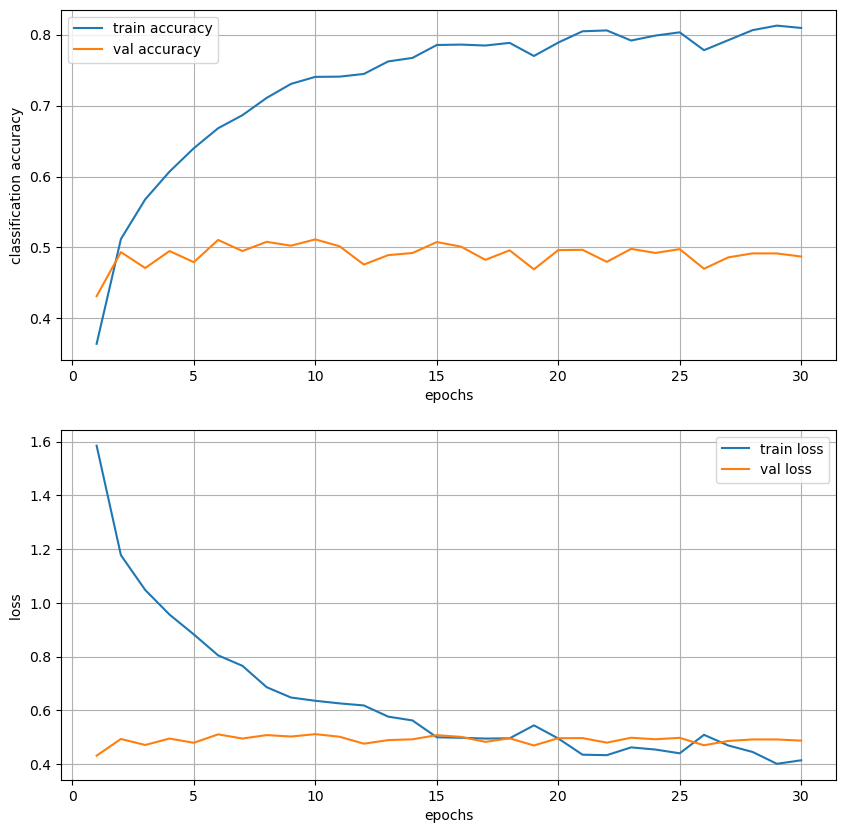

In [ ]:
plt.figure(figsize=(10, 10))

plt.subplot(2,1,1)
plt.plot(epoch,CNN_train_accuracy,label = 'train accuracy')
plt.plot(epoch,CNN_val_accuracy, label= 'val accuracy')
plt.xlabel('epochs')
plt.ylabel('classification accuracy')
#plt.ylim(0.3,0.7)
plt.grid('on')
plt.legend()
plt.subplot(2,1,2)

plt.plot(epoch,CNN_train_loss,label = 'train loss')
plt.plot(epoch,CNN_val_accuracy, label= 'val loss')
plt.legend()
plt.grid('on')
plt.xlabel('epochs')
plt.ylabel('loss ')

plt.savefig('CNN_accuracy_loss.png')

**Compared with multi-layer perceptron model, the CNN  model has a higher classification accuray: around 50% on the validation set.**

**Reduce the number of classes**

By observing the confusion matrix of 16 temperature classification, and  considering the fact that the highest accuracy achieved by models is 50%.We decide to reduce the number of classes by combining several temperatures into one single phase, and the rest to form another phase. The critical temperature of the two phase is between 2.00 and 2.50.

In [ ]:
import numpy as np

# Combine images obtained at 0.25-1.75 to form phase 1 (Label 0)

critical_temp = 2.25
new_labels = np.where((y_train >= 0.25) & (y_train <= critical_temp), 0, 1)

# Print the new labels
print(new_labels)

[0 0 0 ... 1 1 0]


In [ ]:
#combine images obtained at 2.75-4.00 to form phase 2 (Label 2)

In [ ]:
# train models with new labels to classify the images at 2.00 , 2.25 and 2.50